In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
import warnings
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
home = raw_input("Which Home?")
file_path = 'Year1/Home' + home + '_yr1.csv'

Which Home?1


In [4]:
#print(file_path)
dft = pd.read_csv(file_path, names=['Actual'])
#print(dft.head())
intervals = pd.date_range(start='12/1/2014', end='12/1/2015', freq='15min', closed=None)[0:-1]
dft.insert(0, 'Timestamp', intervals)
dft = dft.set_index('Timestamp')

#print(dft.index)
#print(dft['2014-12-1 00:00:00':])

In [9]:
year = raw_input("Enter the Year:")
month = raw_input("Enter the Month:")
date = raw_input("Enter the Date:")
hour = raw_input("Enter the Hour:")
minute = raw_input("Enter the Minute:")
date1 = datetime(int(year), int(month), int(date), int(hour), int(minute) , 0)
print(date1)

Enter the Year:2015
Enter the Month:11
Enter the Date:8
Enter the Hour:0
Enter the Minute:0
2015-11-08 00:00:00


In [18]:
# Find the end interval after 1 day
training_start_date = date1 - timedelta(days=7)
print(training_start_date)
print(date1)
end_dt = date1 + timedelta(days=1) - timedelta(minutes=15)
print(end_dt)
dataset = dft[training_start_date: date1 - timedelta(minutes=15)]

type(dataset['Actual'])

2015-11-01 00:00:00
2015-11-08 00:00:00
2015-11-08 23:45:00


pandas.core.series.Series

In [20]:
p = 0.4
a = 4
# use the y as directly from the house values
y = dataset['Actual'].tolist()
x = cp.Variable(672)

equation = p*x + a*(cp.maximum(0,cp.exp(y-x)))
objective = cp.Minimize(cp.sum(equation))
constraints = [0 <= x]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
print(result)
# The optimal value for x is stored in `x.value`.
print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

1172.3075998427057
[3.4645851  3.57328511 2.95468509 3.53138511 3.1396551  3.2954851
 3.3666851  3.3204851  3.57868511 2.87576509 3.4595851  3.62938511
 2.87566509 3.65648511 3.62108511 3.0178551  5.3755851  3.2114851
 3.4679851  3.64558511 2.82881509 3.67958511 2.88190509 3.59408511
 3.58528511 2.88205509 3.73748511 3.50438511 3.00659509 3.52538511
 3.72268511 2.96873509 4.27538511 2.90903509 2.97794509 3.53538511
 3.3865851  4.17058511 3.65338511 3.0820551  4.27708511 6.00688509
 3.1154651  3.57438511 3.53738511 3.3320851  3.74018511 3.1005151
 3.58298511 4.08438511 6.23738508 3.97278511 3.75638511 3.89418511
 3.86128511 5.1591851  3.2009951  4.67308511 3.0394951  3.0738651
 4.41328511 5.2937851  2.96717509 2.7379051  2.65122513 2.93200509
 2.8165851  2.88810509 6.18218509 3.00476509 5.2580851  5.6812851
 8.66078558 3.92388511 2.96523509 2.96806509 2.85826509 2.99240509
 5.6864851  6.96618513 2.92233509 2.7454951  3.0454951  2.81792509
 2.99703509 4.9256851  2.87685509 2.86141509 2.9

In [25]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [27]:
# find the optimal set of parameters that yields the best performance for our model
# Choose the one with the least resulting AIC value
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dataset,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2546.75893762
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2390.09497966
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2497.55836865
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2077.8729659
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2313.08395937
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2099.04316144
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2290.86243192
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2079.87291594
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2320.77299001
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2239.65151572
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2440.41919629
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2001.76137138
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2209.96037039
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2024.72067155
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2211.99702301
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2010.50815509
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2234.41947523
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2199.59607922
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2671.52030246
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 -

In [28]:
pdq = [1, 1, 1, 1, 0, 0, 1]
print(pdq)

[1, 1, 1, 1, 0, 0, 1]


In [29]:
mod = sm.tsa.statespace.SARIMAX(dft,
                                order=(pdq[1], pdq[2], pdq[3]),
                                seasonal_order=(pdq[4], pdq[5], pdq[6], 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2144      0.005     47.157      0.000       0.206       0.223
ma.L1         -0.8969      0.002   -381.400      0.000      -0.902      -0.892
ma.S.L12      -0.0184      0.005     -3.769      0.000      -0.028      -0.009
sigma2         1.2757      0.006    209.410      0.000       1.264       1.288


In [52]:
# Forecasting
pred = results.get_prediction(start=date1, end=end_dt, dynamic=False)
arima_pred_list = pred.predicted_mean.values.tolist()
y_pred_1 = np.asarray(arima_pred_list)

In [53]:
print(y_pred_1)

[0.66040091 0.63632718 0.63494088 0.58879668 0.63261846 0.5412439
 0.61128317 0.61667899 0.69701352 0.68396751 1.07648811 1.17687303
 1.72751315 1.82580693 2.18840123 2.86040565 1.75439015 2.22254651
 1.52481182 2.23333115 1.60012226 2.06031986 1.62949076 1.94925313
 1.7026765  1.74502979 1.86882259 1.52781242 2.00509497 1.45913891
 1.90426085 1.34682618 1.78934014 1.34810122 1.72112453 1.31523437
 1.73593322 1.1420936  1.7732463  1.35845596 1.95602067 1.15939535
 1.54431501 1.20649667 1.28174134 1.33630533 1.10197453 1.28038898
 1.2942393  1.13820065 1.32460199 1.37726944 1.27800866 1.15905109
 1.37154764 1.2948116  1.29791605 1.14300988 1.63821676 1.11089362
 1.444856   1.62155951 2.71056726 1.71086945 1.5604924  1.40148253
 1.82908739 1.3709766  2.75106029 3.03450279 3.51180002 3.60081781
 3.31343097 2.28292673 2.34173075 2.11399865 1.9782498  1.78842342
 1.69602723 1.466192   1.38541182 1.28668946 1.25697829 1.21954708
 1.74161918 1.21765554 1.15697504 1.09294681 1.09701173 1.30629

In [32]:
print(file_path)
df = pd.read_csv(file_path, names=['Consumption'])
#print(df)
def datetime_range(start, end, delta):
    end += 4*delta
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt for dt in 
       datetime_range(datetime(2014, 12, 1, 0), datetime(2015, 11 , 30 , 23), 
       timedelta(minutes=15))]
df['date/time'] = dts

Year1/Home2_yr1.csv


In [33]:
for i, row in df.iterrows():
#handling seasons
    df.at[i, 'Year'] = row[1].year
    df.at[i, 'Date'] = row[1].day
    df.at[i, 'Month'] = row[1].month
    df.at[i, 'Hour'] = row[1].hour
    df.at[i, 'Minute'] = row[1].minute
    if row[1].month in range(1,4) :
        df.at[i, 'Summer'] = 1
    elif row[1].month in range(4,7):
        df.at[i, 'Spring'] = 1
    elif row[1].month in range(7,10):
        df.at[i, 'Fall'] = 1
    elif row[1].month in range(10,13):
        df.at[i, 'Winter'] = 1
        
#handling peak hours   
    if row[1].hour in [0,1,2,3,4,5,6,7,20,21,22,23]:
        df.at[i, 'Peak Hour'] = 1
    else:
        df.at[i, 'Peak Hour'] = 0
        
#handling holidays & weekends
    if row[1].weekday() in [5,6] :
        df.at[i, 'Holiday'] = 1
    elif row[1].month == 10 and row[1].day == 2:
        df.at[i, 'Holiday'] = 1
    elif row[1].month == 1 and row[1].day == 26:
        df.at[i, 'Holiday'] = 1
    else:
        df.at[i, 'Holiday'] = 0

df['Spring'].fillna(0,inplace=True)
df['Fall'].fillna(0,inplace=True)
df['Summer'].fillna(0,inplace=True)
df['Winter'].fillna(0,inplace=True)

In [34]:
for i, row in df.iterrows():
    if row[1] == date1:
        break
x_train = df[['Year','Date','Month','Hour','Minute','Summer','Winter', 'Fall','Spring' , 'Holiday', 'Peak Hour']][i-672:i]
y_train = df[['Consumption']][i-672:i]
x_test = df[['Year','Date','Month','Hour','Minute','Summer','Winter', 'Fall','Spring' , 'Holiday', 'Peak Hour']] [i:96+i]
y_test = df[['Consumption']][i:96+i]

In [35]:
print(x_train)

         Year  Date  Month  Hour  Minute  Summer  Winter  Fall  Spring  \
32160  2015.0   1.0   11.0   0.0     0.0     0.0     1.0   0.0     0.0   
32161  2015.0   1.0   11.0   0.0    15.0     0.0     1.0   0.0     0.0   
32162  2015.0   1.0   11.0   0.0    30.0     0.0     1.0   0.0     0.0   
32163  2015.0   1.0   11.0   0.0    45.0     0.0     1.0   0.0     0.0   
32164  2015.0   1.0   11.0   1.0     0.0     0.0     1.0   0.0     0.0   
32165  2015.0   1.0   11.0   1.0    15.0     0.0     1.0   0.0     0.0   
32166  2015.0   1.0   11.0   1.0    30.0     0.0     1.0   0.0     0.0   
32167  2015.0   1.0   11.0   1.0    45.0     0.0     1.0   0.0     0.0   
32168  2015.0   1.0   11.0   2.0     0.0     0.0     1.0   0.0     0.0   
32169  2015.0   1.0   11.0   2.0    15.0     0.0     1.0   0.0     0.0   
32170  2015.0   1.0   11.0   2.0    30.0     0.0     1.0   0.0     0.0   
32171  2015.0   1.0   11.0   2.0    45.0     0.0     1.0   0.0     0.0   
32172  2015.0   1.0   11.0   3.0     0

In [36]:
print(y_train)

       Consumption
32160      0.15006
32161      2.35490
32162      0.19504
32163      2.05130
32164      2.07620
32165      1.45130
32166      0.36169
32167      0.64901
32168      0.42127
32169      0.59175
32170      2.02640
32171      0.56398
32172      0.56368
32173      0.31340
32174      0.56205
32175      0.62080
32176      0.82664
32177      1.75790
32178      0.56000
32179      0.56083
32180      0.56167
32181      0.35156
32182      0.56686
32183      3.36580
32184      0.79611
32185      0.63484
32186      0.56603
32187      0.43374
32188      0.50074
32189      0.56727
...            ...
32802      0.70843
32803      1.77260
32804      0.71980
32805      1.30790
32806      3.58680
32807      1.42800
32808      1.17850
32809      1.44640
32810      1.76800
32811      0.76104
32812      0.55891
32813      0.66486
32814      0.71240
32815      0.57966
32816      0.65571
32817      0.39824
32818      0.52553
32819      0.39205
32820      0.58946
32821      0.50103
32822      2

Mean absolute error LR: 1.177436844


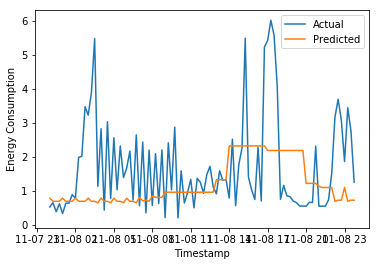

In [49]:
regr = AdaBoostRegressor(base_estimator=None, n_estimators=50, learning_rate=1.0, loss='linear', random_state=None)
regr.fit(x_train, y_train)
y_pred_2 = regr.predict(x_test)
print("Mean absolute error LR: %.9f"
      % mean_absolute_error(y_test,y_pred_r))
dur = [dt for dt in 
       datetime_range(datetime(int(year), int(month), int(date), int(hour), int(minute)), datetime(2015, 12 , 31 , 23), 
       timedelta(minutes=15))]
dur = dur[0:96]
plt.plot(dur, y_test, label="Actual")
plt.plot(dur, y_pred_2, label="Predicted")
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

In [60]:
len(y_pred_2)

96

In [76]:
def df(y , prev_x):
    if y > prev_x:
        return 0.4
    else:
        return 0.4 + 4

In [83]:
result = []
for y in y_pred_1:
    print(y)
    cur_x = 3 # The algorithm starts at x=3
    rate = 0.01 # Learning rate
    precision = 0.000001 #This tells us when to stop the algorithm
    previous_step_size = 1 #
    max_iters = 10000 # maximum number of iterations
    iters = 0 #iteration counter
#     df = lambda x: 2*(x+5)
    
    while previous_step_size > precision and iters < max_iters:
        prev_x = cur_x #Store current x value in prev_x
        
        cur_x = cur_x - rate * df(y, prev_x) #Grad descent
        previous_step_size = abs(cur_x - prev_x) #Change in x
        iters = iters+1 #iteration count
        #print("Iteration",iters,"\nX value is",cur_x) #Print iterations
    #print(iters)
    print(cur_x)


0.6604009099559636
-39.16
0.6363271798705528
-39.16
0.6349408783382388
-39.16
0.5887966776925968
-39.2
0.6326184632776164
-39.16
0.5412438981879949
-39.24
0.6112831738680988
-39.2
0.616678988070196
-39.2
0.6970135226388456
-39.12
0.6839675088046637
-39.12
1.0764881106299107
-38.76
1.1768730322296674
-38.68
1.727513154930541
-38.16
1.8258069298961606
-38.08
2.1884012250172065
-37.76
2.860405651854755
-37.16
1.7543901458555062
-38.16
2.222546509026032
-37.72
1.5248118161874733
-38.36
2.2333311520083847
-37.72
1.6001222641119284
-38.28
2.0603198617616014
-37.88
1.6294907637340716
-38.28
1.949253129359087
-37.96
1.7026765005392035
-38.2
1.7450297921229272
-38.16
1.8688225919669053
-38.04
1.5278124212153312
-38.36
2.005094965827203
-37.92
1.4591389090578573
-38.44
1.9042608534455543
-38.0
1.346826180934317
-38.52
1.7893401357496963
-38.12
1.3481012162568176
-38.52
1.7211245287756403
-38.2
1.3152343729068563
-38.56
1.7359332239409184
-38.16
1.1420935995419332
-38.72
1.7732463023686726
-38.12